In [1]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import seaborn as sns
from sentence_transformers import SentenceTransformer
from transformers import AutoModel, AutoTokenizer, pipeline
import requests
import os
import torch
import umap
import umap.plot
import hdbscan

c:\Users\julia\OneDrive\Documents\GitHub\tad_assignment2\tad2_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_final = pd.read_csv('data\\manifestos_ger.csv')

data_final.cmp_code = pd.to_numeric(data_final.cmp_code, errors='coerce').astype(np.int64, errors='ignore')
data_final.partyabbrev = [p if p not in ['LINKE', 'L-PDS', 'PDS'] else 'LINKE' for p in data_final.partyabbrev]
data_final.edate = pd.to_datetime(data_final.edate)
data_final['year'] = data_final.edate.dt.year


data_env = data_final[(data_final.cmp_code == 501) & ~(data_final.partyname.isin(['Pirates', 'South Schleswig Votersâ Union']))]
data_env['half_decade'] = data_env.year//5*5
data_env['decade'] = data_env.year//10*10

conds = np.r_[np.NINF, np.linspace(10, 90, 9), 95, 98, np.inf]
choice = ['ECO', 'LEF', 'SOC', 'LIB', 'CHR', 'CON', 'NAT', 'AGR', 'ETH', 'SIP', 'DIV', 'MI']

data_env['partyfam'] = pd.cut(data_env.parfam, bins=conds, labels=choice)

plt_dt = (data_env
 .groupby(['year', 'partyabbrev'])
 .agg({'cmp_code': 'count'})
 .reset_index()
)

c:\Users\julia\OneDrive\Documents\GitHub\tad_assignment2\tad2_env\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (192) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<AxesSubplot:xlabel='partyabbrev', ylabel='cmp_code'>

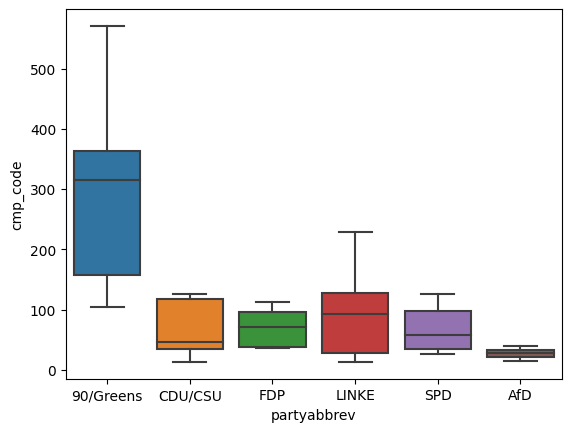

In [3]:
sns.boxplot(data=plt_dt, x='partyabbrev', y='cmp_code')

<AxesSubplot:xlabel='year', ylabel='cmp_code'>

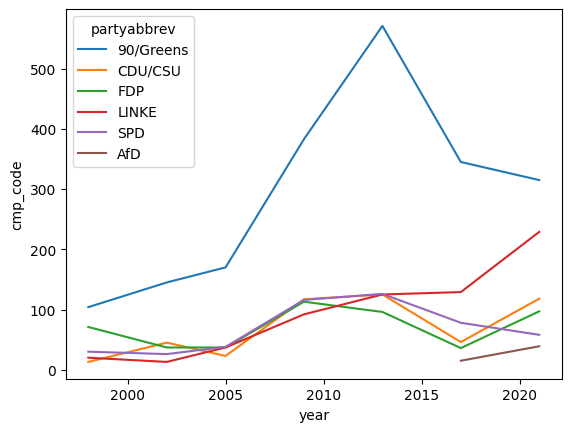

In [4]:
sns.lineplot(data=plt_dt, x='year', y='cmp_code', hue='partyabbrev')

In [41]:
dat = (data_env
 .groupby('year')
 .agg({'cmp_code': 'count', 
       'partyname': 'nunique', 
       }))

In [42]:
dat['new_var'] = dat.cmp_code/dat.partyname

I settled on a dataset of German party manifestos. The dataset includes six parties: The Greens, CDU/CSU, FDP, die Linke, SPD and AfD. I removed Piraten and Südschleßischer Wählerverband (SSW) because they do not substantially affect the German public discourse on environment protection, as they are small and rather negligable parties. I also transformed the parties that die Linke merged from pre-2007 and included it as die Linke.

The dataset covers German party manifestos from 1998 onwards. In this period, there were 7 elections (which coincides with election manifestos) in 4 year intervals (with one 3 year interval between 2002 and 2005, due to Gerhard Schrörder's lost vote of no confidence which resulted in a shorter legislative period). For my research question, I am only focusing on those parts of the manifestos that refer to environment protection (code 501). The dataframe includes 4178 texts and 4148 unique texts. There are some duplicates, as either the policy demand in the manifesto did not change, or the line is very short, such as 'Klimaschutz' or 'Klimawandel'. The data is heavily skewed toward the manifestos of the Greeens which make almost half (48.7%) of all documents. The remaining parties account for between 10% to 15% of the documents, with AfD as an exception, making up only 1.2% (this is equivalent to 54 documents) and being present for only 2017 and 2021 (the party was only fonuded in 2013 and joined the Bundestag in 2017). Given the Green's programmatic/ ideologic focus their overrepresentation is to be expected. 

In general, there is a quite substantial increase in the number of documents over time, tripling from 6152 in 1998 to 18459 2021 (part of which can be accounted for by the increase in the number of parties). However, this could also exhibit the transition of party politics determined by traditional electoral milieus (like SPD -> workers' party) to a competition for the political center. Taking the mean number of texts per party, there is still a substantial increase from ~1200 to ~2600 documents. With regards to the filtered dataset (filtering out parties & subsetting environment protection coded documents) a slightly different trend exists, with 48 documents per party in 1998, 143 in 2021, and a peak of 209 in 2013, mostly driven by an increase of documents by the Greens' election manifesto.

While I did create a document-term amtrix, I do not actually intend to use it, as I would like to employ [BERTopic](https://arxiv.org/pdf/2203.05794.pdf) to create the topic modelling. BERTopic does not require a document-term matrix because it creates the topics by clustering word and document embedding vectors. The clustering process is facilitated by a dimensionality reduction step via UMAP. The reduced embeddings are then clustered with HDBSCAN.

While traditional Topic modelling techniques employ TF-IDF, which combines two statistic measures, the term frequency and the inverse document frequency. BERTopic modifies this to a cluster-based TF-IDF score, that concetanates documents per cluster into a single cluster and 

BERTopic allows to use different word embeddings. Depending on which language model is used for the calculations of the embeddings, the modelled topics will differ quite substantially. In this case I am trying out four different language models. First, I am using the standard multilanguage sentence transformer of the BERTopic library. Next, I am using the standard german language model, also from the BERTopic. Finally, I am using a [German BERT model](https://huggingface.co/mox/gBERt_base_twitter_sentiment_politicians) that is finetuned on twitter data of German politicians during the 2021 parliamentary election. Rather than using the embdeddings as is, I extract sentence embeddings that take contextual information of the words in the each document (which essentially are sentences) into consideration. The word embeddings are based on the BERTopic default language model, the Sentence BERT (SBERT) ['all-MiniLM-L6-v2'](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) framework.

In [5]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(data_env.text.to_list(), show_progress_bar=True)

vectorizer_model = CountVectorizer(stop_words=stopwords.words('german'))
german_model = BERTopic(verbose=True, vectorizer_model=vectorizer_model, language='german')

german_parl = AutoModel.from_pretrained("chkla/parlbert-topic-german", output_hidden_states=True)
german_parl_model = BERTopic(verbose=True, embedding_model=german_parl)

Batches: 100%|██████████| 131/131 [01:02<00:00,  2.11it/s]
Some weights of the model checkpoint at chkla/parlbert-topic-german were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
german_parl_model.fit(data_env.text.to_list())

Batches: 100%|██████████| 131/131 [00:42<00:00,  3.06it/s]
2022-11-17 19:21:59,192 - BERTopic - Transformed documents to Embeddings
2022-11-17 19:22:21,579 - BERTopic - Reduced dimensionality
2022-11-17 19:22:21,817 - BERTopic - Clustered reduced embeddings


In [7]:
german_parl_embeds = [german_parl_model.embedding_model.embed_documents(t) for t in data_env.text]

In [8]:
import umap
umap_embedd = umap.UMAP(n_neighbors=15,
                        n_components=5,
                        metric='cosine').fit_transform(german_parl_embeds)

In [9]:
clusters = hdbscan.HDBSCAN(min_cluster_size=5,
                           metric='euclidean',
                           cluster_selection_method='eom').fit(umap_embedd)

In [10]:
len(german_parl_model.get_topics())

83

In [12]:
hover_data = pd.DataFrame([{'text': row['text'],
                            'party': row['party'],
                            'index': i} for i, row in data_env.iterrows()])

In [91]:
result.shape

(4178, 3)

In [13]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import CategoricalColorMapper, HoverTool, ColumnDataSource
from bokeh.palettes import Colorblind

In [ ]:
data_env.party_abbrev

In [15]:
len(data_env.text)

4178

RangeIndex(start=0, stop=4178, step=1)

In [30]:
umap_data = umap.UMAP(n_neighbors=4, n_components=2, min_dist=0.0, metric='cosine').fit_transform(german_parl_embeds)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = clusters.labels_

datasource = ColumnDataSource(
    data=dict(
        x=result['x'].to_list(),
        y=result['y'].to_list(),
        text=data_env['text'].to_list(),
        party=data_env['party'].to_list(),
        cluster=result['labels'].to_list()
    )
)

color_dict = {
    '90/Greens' : 'green',
    'LINKE' : 'blueviolet',
    'SPD' : 'red',
    'FDP' : 'yellow',
    'CDU/CSU' : 'black',
    'AfD' : 'blue'
}

color_mapping = CategoricalColorMapper(
    palette=list(color_dict.values()),
    factors=list(color_dict.keys())
)

tooltips = [
    ('party', "@$party"),
    ('text', "@$text"),
    ("(x, y)", "($x, $y)"),
    ('index', '$index'),
    ('cluster', '@$cluster')
]

plot_figure = figure(
    title="UMAP Projection of German party manifestos' environment protection demands",
    plot_width=800, 
    plot_height=800,
    tools=('pan, wheel_zoom, reset'),
    tooltips=tooltips
)

plot_figure.circle(
    'x', 'y', source=datasource,
    fill_color=dict(field='party', transform=color_mapping),
    line_color="grey", line_alpha=0.6, fill_alpha=0.6, size=4
)

show(plot_figure)

In [ ]:
data=dict(
        x=result['x'].to_list(),
        y=result['y'].to_list(),
        text=data_env['text'].to_list(),
        party=data_env['party'].to_list(),
        cluster=result['labels'].to_list()
    )

tooltips = [
    ('party', "@$party"),
    ('text', "@$text")
]


party = data_env['party'].unique()
p = figure(title="Fruit counts by year", 
           tools="hover", tooltips=tooltips)
p.circle(x='x', y='y', width=0.9, source=data,
             legend_label='party')

In [42]:
show(p)

In [27]:
plot_figure.circle(
    x='x', 
    y='y', 
    color=
    source=datasource,
    fill_color=dict(field='party', transform=color_mapping),
    line_color="grey", line_alpha=0.6, fill_alpha=0.6, size=4
)

show(plot_figure)

In [24]:
result

,x,y,labels,party,text,index
0,5.014914,10.511575,6,NaN,NaN,0
1,1.699954,-0.318323,13,NaN,NaN,1
2,5.003908,10.578611,6,NaN,NaN,2
3,8.615928,1.393010,114,NaN,NaN,3
4,8.709826,0.649347,114,NaN,NaN,4
...,...,...,...,...,...,...
4173,-5.816091,-0.160370,81,NaN,NaN,4173
4174,8.848570,2.910579,76,NaN,NaN,4174
4175,2.748094,1.534250,21,NaN,NaN,4175
4176,-0.602879,1.412220,37,NaN,NaN,4176


In [95]:
data_env.partyabbrev.unique()

array(['90/Greens', 'LINKE', 'SPD', 'FDP', 'CDU/CSU', 'AfD'], dtype=object)

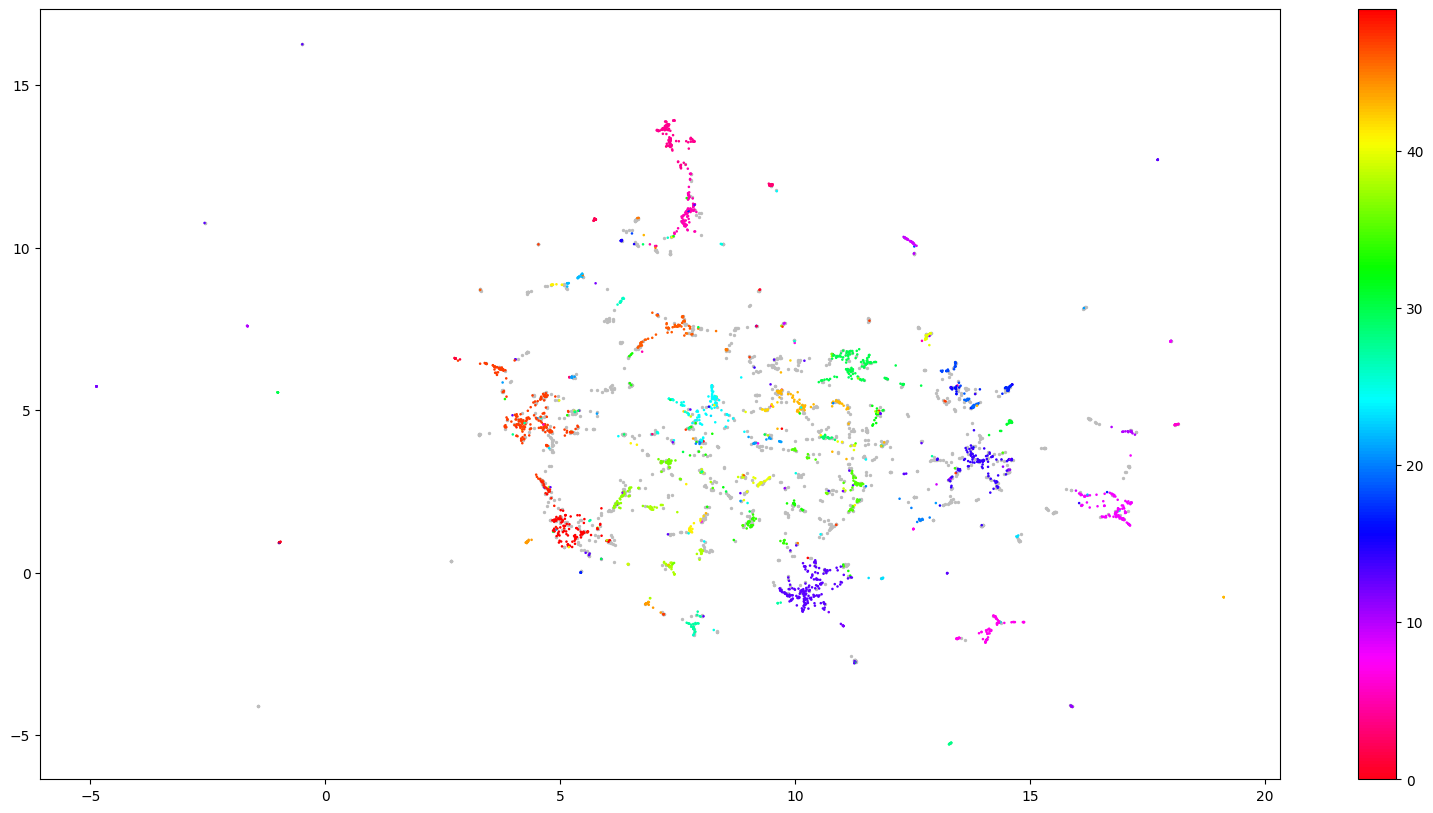

In [81]:
import matplotlib.pyplot as plt

umap_data = umap.UMAP(n_neighbors=4, n_components=2, min_dist=0.0, metric='cosine').fit_transform(german_parl_embeds)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = clusters.labels_

fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=2)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=.7, cmap='hsv_r')
plt.colorbar()

In [69]:
docs_df = pd.DataFrame(data_env, columns=['text'])
docs_df['Topic'] = clusters.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_cluster = docs_df.groupby(['Topic'], as_index=False).agg({'text': ' '.join})

In [70]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(docs, m):
    count = CountVectorizer(stop_words=stopwords.words('german')).fit(docs)
    t = count.transform(docs).toarray()
    tf = np.divide(t.T, t.sum(axis=1))
    idf = np.log(np.divide(m, t.sum(axis=0))).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    
    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_cluster.text.values, m=len(data_env))

As dicussed above, there is no actual term-document matrix in BERTopic, but rather a term-cluster matrix. The resulting matrix has 32 clusters with 9207 words (after excluding German stopwords)). 

In [71]:
pd.DataFrame(tf_idf.T, columns=count.get_feature_names_out())

,00,000,06,09,10,100,107,11,110,113,...,überwachung,überwachungsbedürftigen,überwiegend,überwinden,überwunden,überzeugen,überzeugt,überzeugung,übliche,übrigen
0,0.000000,0.001518,0.000000,0.000000,0.001697,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000496,0.000541,0.000496,0.000496,0.000000,0.000000,0.000496,0.000541,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.004329,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.005654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.560326,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [74]:
def extract_top_words_per_cluster(tf_idf, count, docs_per_cluster, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_cluster.Topic)
    indices = tf_idf.T.argsort()[:,-n:]
    top_n_words = {label : 
        [(words[j], tf_idf.T[i][j]) for j in indices[i]][::-1]
        for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_size(df):
    topic_sizes = (df.groupby(['Topic'])
                   .text
                   .count()
                   .reset_index()
                   .rename({'Topic': 'Topic', 'text': 'Size'},
                           axis='columns')
                   .sort_values('Size', ascending=False))
    return topic_sizes


top_n_words = extract_top_words_per_cluster(tf_idf, count, docs_per_cluster)
topic_sizes = extract_topic_size(docs_df)

topic_sizes.words = [' '.join(word) for word in [top_n_words[row.Topic][:10] for _, row in topic_sizes.iterrows()]]
topic_sizes.head(10)


,Topic,Size
0,-1,1992
12,11,310
32,31,180
2,1,137
21,20,124
10,9,106
22,21,103
19,18,101
16,15,98
34,33,94


In [113]:
vectorizer_model = CountVectorizer(stop_words=stopwords.words('german'))

topic_model = BERTopic(verbose=True, embedding_model=model)

topics, probs = topic_model.fit_transform(data_env.text.to_list())

Batches: 100%|██████████| 131/131 [00:40<00:00,  3.23it/s]
2022-11-16 20:05:46,534 - BERTopic - Transformed documents to Embeddings
2022-11-16 20:05:53,724 - BERTopic - Reduced dimensionality
2022-11-16 20:05:53,988 - BERTopic - Clustered reduced embeddings


In [114]:
topics_over_time = topic_model.topics_over_time(data_env.text.to_list(), 
                                                data_env.year.to_list())
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=12)

7it [00:00,  9.69it/s]


In [97]:
hierarchical_topics = topic_model.hierarchical_topics(data_env.text.to_list())

100%|██████████| 72/72 [00:00<00:00, 256.48it/s]


In [98]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [99]:
topic_model.visualize_topics()

In [100]:
topic_model.visualize_heatmap(n_clusters=5, top_n_topics=40, width=1000, height=1000)

In [103]:
topic_model.visualize_barchart(custom_labels=False, top_n_topics=12)

In [106]:
topics_per_class = topic_model.topics_per_class(data_env.text, classes=data_env.partyabbrev)
topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=12)

6it [00:00, 19.47it/s]
